### **Time Series forecasting using Tensorflow**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf
import time_series_functionalities as tsf

2025-03-27 15:11:51.833579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### RESULTS:
baseline_results = {'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

model_1_results = {'mae': 568.06366,
 'mse': 1159591.9,
 'rmse': 1076.8435,
 'mape': 2.5265791,
 'mase': 0.9979305}

model_2_results = {'mae': 597.3115,
 'mse': 1246714.0,
 'rmse': 1116.5635,
 'mape': 2.696134,
 'mase': 1.0441062}

model_3_results = {'mae': 1272.8289,
 'mse': 5554035.5,
 'rmse': 2356.7002,
 'mape': 5.8320484,
 'mase': 2.2649276}

In [3]:
data = pd.read_csv('bitcoin_data.csv', parse_dates=['Date'], index_col=['Date'])
# parse the date column and tell pandas column 1 is date-time

In [4]:
# reduce the data to only have date and closing price of bit-coin
bitcoin_prices = pd.DataFrame(data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


**20. Preparing data for input to sequence models**

* To use the conv1D, we need an input shape of `(batch_size, timesteps, input_dim)`. 
* Our previously used windowed data is not in that shape yet...
* Our data input shape is: `(window_size,)`
* We would want it to be `(1,window_size)`, hence we need to expand dimensions 

In [5]:
#  using the dataframe of bit-coin prices
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

# WINDOWING 
HORIZON = 1
WINDOW_SIZE = 7

full_windows,full_labels = tsf.make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)

# train-test split without windowing
train_percent = 80
split_size = int(train_percent*0.01*len(timesteps))
X_train,y_train = timesteps[:split_size],prices[:split_size]
X_test,y_test = timesteps[split_size:],prices[split_size:]

# create train and test windows split
train_windows,test_windows,train_labels,test_labels = tsf.make_train_test_splits(full_windows,full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

In [37]:
# experimenting to convert our data in the needed format
x = tf.constant(train_windows[0])

# creating a layer to expand dimensions
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis = 1)) # add an extra dimension for `input_dim`

# testing our lambda function layer
print(f'Original input: {x}')
print(f'Original shape: {x.shape}') # (window_size,)
print(f'Expanded shape:{expand_dims_layer(x).shape}') # (window_size,1)
print(f'Expanded input: {expand_dims_layer(x)}')

Original input: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
Original shape: (7,)
Expanded shape:(7, 1)
Expanded input: [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [7]:
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,savepath='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=f'{savepath}/{model_name}.keras',
                                              verbose = 0,
                                              monitor='val_loss',
                                              save_best_only = True
                                              )

**Note:** Avoid using Lambda functions, it creates serialization issues, while saving and loading models

**21. Building Model 4 (conv1D) (horizon = 1, window = 7)**

In [52]:
# 1. model creation

# expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis = -1),name ='expand_dims',output_shape=(WINDOW_SIZE,1))

@kr.utils.register_keras_serializable(package="ExpandDims")
class ExpandDims(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    
    def call(self,inputs):
        return tf.expand_dims(inputs,axis=1)

inputs = tf.keras.layers.Input(shape = (7,))
x = ExpandDims()(inputs)

# adding a conv1D layer
x = tf.keras.layers.Conv1D(filters=256,kernel_size=7,strides = 2, padding = 'causal',activation='relu')(x)

# pooling after convolution
# x = tf.keras.layers.GlobalAveragePooling1D()(x) # not needed

# adding the dense layer
outputs = tf.keras.layers.Dense(units = HORIZON)(x)

model_4 = tf.keras.models.Model(inputs,outputs,name='model_4')


# 2. model compiling
model_4.compile(loss = 'mae',optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mse'])

# 3. getting model summary
model_4.summary()

Model: "model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_10 (ExpandDims)     │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1, 256)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1, 1)           │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# 3. fit the model
model_4.fit(x=train_windows,
            y=train_labels,
            epochs = 100,
            batch_size = 128,
            validation_data = (test_windows,test_labels),
            verbose = 1,
            callbacks=[create_model_checkpoint(model_4.name)]
            )

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2079.7090 - mae: 2079.7090 - mse: 12238246.0000 - val_loss: 2893.8906 - val_mae: 2893.8904 - val_mse: 18739174.0000
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 376.2551 - mae: 376.2551 - mse: 470194.0000 - val_loss: 1153.2163 - val_mae: 1153.2163 - val_mse: 3792981.7500
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 195.2355 - mae: 195.2355 - mse: 179873.5938 - val_loss: 1157.9136 - val_mae: 1157.9136 - val_mse: 3785602.7500
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 180.5722 - mae: 180.5722 - mse: 162307.7188 - val_loss: 1007.3335 - val_mae: 1007.3335 - val_mse: 3234157.0000
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 170.8356 - mae: 170.8356 - mse: 150782.1094 - val_loss: 976.3969 - val_mae: 976.3969 - val_mse: 3112217.7500
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 167.5655 - mae: 167.5655 - mse: 147323.3594 - val_loss: 985.2452 - val_mae: 985.2452 - 

In [54]:
model_4.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 282.6527 - mae: 282.6527 - mse: 345837.8438


[566.3369140625, 566.3369140625, 1167021.125]

In [55]:
# load in saved best performing model_4 and evaluate it on test data
model_4 = tf.keras.models.load_model(f'model_experiments/{model_4.name}.keras',custom_objects={'ExpandDims': ExpandDims})

In [59]:
model_4.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 282.6527 - mae: 282.6527 - mse: 345837.8438


[566.3369140625, 566.3369140625, 1167021.125]

In [60]:
# making forcasts with the model_1 on test dataset
def make_preds(model,input_data):
    '''
    Uses model to make predictions on input data
    '''

    forcast = model.predict(input_data)
    return tf.squeeze(forcast) # return 1D array of predictions

model_4_preds=make_preds(model_4,test_windows)
len(model_4_preds),model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8875.964, 8791.402, 9028.578, 8794.427, 8742.846, 8738.833,
        8689.777, 8532.577, 8465.639, 8529.883], dtype=float32)>)

In [61]:
model_4_results = tsf.evaluate_time_series(tf.squeeze(test_labels),model_4_preds)
model_4_results

{'mae': 566.3369,
 'mse': 1167021.1,
 'rmse': 1080.2875,
 'mape': 2.5285356,
 'mase': 0.99489707}

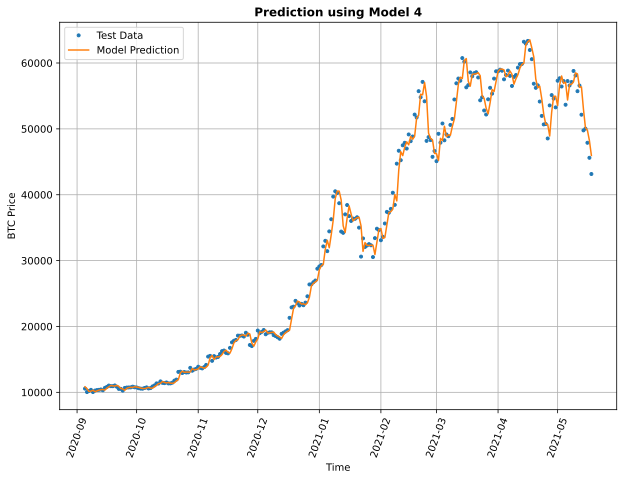

In [62]:
# plotting model_3 predictions
offset = 300
end = None
plt.figure(figsize=(10,7))

# account for test_window offset and index into test_labels to ensure correct plotting
tsf.plot_time_series(timesteps = X_test[-len(test_windows):] , values = test_labels[:,0],start = offset,end=end,label = "Test Data",format='.')
tsf.plot_time_series(timesteps = X_test[-len(test_windows):] , values = model_4_preds,start = offset,end=end,label = "Model Prediction", format='-',xtick_rotation=70,ylabel='BTC Price')
plt.title("Prediction using Model 4",fontsize = 12, fontweight='bold')
plt.show()

***-- CONTD IN NEXT NOTEBOOK --***